# Movie CFO

## Introduction to the tool

We will create a new class MovieCFO which will help us to process the historical movie data to project the gross revenue for the upcoming movies and compute whether the movie will be profitable with the following assumption:

$$ \text{Gross Margin} = \frac{\text{Gross Revenue} - \text{Budget}}{\text{Gross Revenue}} $$

In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import geopandas as gpd
import folium
import pickle
import networkx as nx

from scipy.stats import f_oneway

pd.options.display.max_columns = None

## The Researcher

In [221]:
class MDO_Researcher():
    """Core member of the Movie Director Office, the researcher will try to collect and clean the data.
    The data will be used by the other members for exploration, visualization, and prediction.

    Attributes
    ----------
    pre : pd.DataFrame
        Pre-release dataset
    after : pd.DataFrame
        After-release dataset
    full : pd.DataFrame
        Merged dataset
    pred_columns : list
        List of predictors
    success_columns : list
        List of success metrics
    
    Initiation
    ----------

    from_directory(directory:str) -> None
        Create a MDO_Researcher object from a directory containing the pre and after release datasets.
    
    from_enriched(
        path:str="../data/enriched_data.csv",
        successes:list=[
            "gross", "num_voted_users", "num_user_for_reviews", "imdb_score", "movie_facebook_likes",
            "profit", "num_critic_for_reviews"],
            **class_arg) -> None
        Initiate the dataset from a csv file with enriched data.

        
    Methods
    -------

    prepare_data(verbose:bool=False) -> None
        Prepare the data by dropping duplicates and merging the two datasets.

    split_genres(top:int=10, verbose:bool=False) -> None
        Split the top genres into individual columns and add one for all other genres.
    
    enrich_with_country(
        path:str="../data/countries_shape/ne_110m_admin_0_countries.shp",
        country_replacement:dict={"United States of America": "USA", "United Kingdom": "UK", "Czechia": "Czech Republic"},
        columns:list=["NAME", "POP_EST", "GDP_MD"], replace:bool=True) -> None
        Enrich the data with information about the country of the movie.
    
    enrich_with_actors(
        path:str="../data/actors.pickle",
        centralities:list=["degree", "closeness", "betweenness"], replace:bool=True) -> None
        Enrich the data with information about the network of actors across movies.
    
    enrich_all(
        save:bool=False, path:str="../data/enriched_dataset.csv",
        country:bool=True, actors:bool=True, country_par:dict={}, actors_par:dict={}) -> None
        Enrich the data with all the available methods. It includes addition of profit as a success metric.
    """

    def __init__(
        self,
        pre:str = "../data/pre_release.csv",
        after:str = "../data/after_release.csv") -> None:

        self.pre = pd.read_csv(pre)
        self.after = pd.read_csv(after)
        self.full = None
        self.pred_columns = None
        self.success_columns = None

    ### Automatic generation:

    @classmethod
    def from_directory(cls, directory:str) -> None:
        """Create a MovieCFO object from a directory containing the pre and after release datasets.

        Parameters
        ----------
        directory : str
            Path to the directory containing the two datasets
        """
        for file in os.listdir(directory):
            if "pre" in file and file.endswith(".csv"):
                pre = os.path.join(directory, file)
            elif "after" in file and file.endswith(".csv"):
                after = os.path.join(directory, file)
        return cls(pre, after)
    
    ### Initiate class with enriched data

    @classmethod
    def from_enriched(
        cls,
        path:str = "../data/enriched_data.csv",
        successes = [
            "gross", "num_voted_users", "num_user_for_reviews",
            "imdb_score", "movie_facebook_likes", "profit", "num_critic_for_reviews"],
        **class_arg) -> None:
        """Initiate the dataset from a csv file with enriched data.

        Parameters
        ----------
        path : str, optional
            Path to the enriched dataset, by default "../data/enriched_data.csv"
        successes : list, optional
            Columns which are observed after the movie release.
        """
        obj = cls(**class_arg)
        obj.full = pd.read_csv(path)
        obj.success_columns = successes
        obj.pred_columns = [col for col in obj.full.columns if col not in obj.success_columns]
        return obj

    #># Method 1:

    def prepare_data(self, verbose:bool=False) -> None:
        """Prepare the data by dropping duplicates and merging the two datasets.

        Parameters
        ----------
        verbose : bool, optional
            Display execution details, by default False
        """
        # ---
        if verbose:
            print("".join([
                f"Pre-release: {self.pre.shape[0]} rows with {self.pre.movie_title.unique().shape[0]}",
                " unique movies\n",
                f"After-release: {self.after.shape[0]} rows with {self.after.movie_title.unique().shape[0]}",
                " unique movies\n"
            ]))

        # Dropping duplicates before merging
        self.pre.drop_duplicates(subset=["movie_title"], inplace=True)
        self.after.drop_duplicates(subset=["movie_title"], inplace=True)

        # Merging the two datasets
        self.full = pd.merge(self.pre, self.after, on="movie_title", how="inner", suffixes=("_pred", "_success"))
        self.pred_columns = [col for col in self.pre.columns]
        self.success_columns = [col for col in self.after.columns if col != "movie_title"]
        
        # ---
        if verbose:
            print(f"Full dataset: {self.full.shape[0]} unique movies.")

    #># Method 2:

    def split_genres(self, top:int=10, verbose:bool=False) -> None:
        """Split the genres into individual columns.

        Parameters
        ----------
        top : int, optional
            Number of top genres to keep, by default 10
        verbose : bool, optional
            Display execution details, by default False
        """

        # Get the top genres and the rest 
        self.full["genres"] = self.full["genres"].str.split("|")
        genre_count = self.full["genres"].explode().value_counts()
        top_genres = genre_count.head(top).index.tolist()
        other_genres = genre_count.index.difference(top_genres).tolist()

        if verbose:
            print(f"Top genres:")
            print(genre_count.head(top))

        # Create the columns
        if not self.full.columns.str.contains("genre_").any():
            for genre in top_genres:
                self.full[f"genre_{genre}"] = self.full["genres"].apply(lambda x: genre in x)
            self.full["genre_other"] = self.full["genres"].apply(lambda x: set(x).intersection(other_genres) != set())
        
        # Update the list of predictors
        self.pred_columns += [f"genre_{genre}" for genre in top_genres] + ["genre_other"]
        self.pred_columns.remove("genres")

    #># Method 3:

    def enrich_with_country(
        self,
        path:str = "../data/countries_shape/ne_110m_admin_0_countries.shp",
        country_replacement:dict = {
            "United States of America": "USA",
            "United Kingdom": "UK",
            "Czechia": "Czech Republic"
        },
        columns:list = ["NAME", "POP_EST", "GDP_MD"],
        replace:bool = True
        ) -> None:
        """
        Enrich the data with information about the country of the movie.

        Parameters
        ----------
        path : str, optional
            Path to the shapefile containing the countries, by default "../data/countries_shape/ne_110m_admin_0_countries.shp"
        country_replacement : dict, optional
            Dictionary to replace country names, by default {"United States of America": "USA", "United Kingdom": "UK", "Czechia": "Czech Republic"}
        columns : list, optional
            Columns to keep from the shapefile, by default ["NAME", "POP_EST", "GDP_MD"] (NAME needs to be present)
        replace : bool, optional
            Replace the full dataset with the enriched one, by default True

        Returns
        -------
        pd.DataFrame
            Enriched dataset
        
        Raises
        ------
        KeyError
            If the chosen columns are not available in the dataset
        FileNotFoundError
            If the file is not found      
        """

        # Load the shapefile and select the columns
        try:
            countries_mask = gpd.read_file(path)
        except FileNotFoundError:
            raise FileNotFoundError("The countries shapefile was not found")
        try:
            countries_mask = countries_mask[columns]
            countries_mask.columns = [col.lower() for col in columns]
        except KeyError:
            raise KeyError("The chosen columns are not available in the dataset")
        
        # Rename the countries and merge the datasets
        for key in country_replacement.keys():
            countries_mask.name = countries_mask.name.str.replace(key, country_replacement[key])
        enriched_data = self.full.merge(countries_mask, left_on="country", right_on="name", how="left")
        enriched_data.drop(columns="name", inplace=True)

        if replace:
            self.full = enriched_data
            self.pred_columns += [col for col in countries_mask.columns if col != "name"]
        
        return enriched_data

    #># Method 4:

    def enrich_with_actors(
            self,
            path:str = "../data/actors.pickle",
            centralities:list = ["degree", "closeness", "betweenness"],
            replace:bool = True) -> None:
        """Enrich the data with information about the network of actors across movies.
        It requires the actors agent to generate the network first.

        Parameters
        ----------
        path : str, optional
            Path to the actors network, by default "../data/actors.pickle"
        centralities : list, optional
            Centralities to add to the dataset, by default "degree", "closeness", and "betweenness"
        replace : bool, optional
            Replace the full dataset with the enriched one, by default True

        Raises
        ------
        FileNotFoundError
            If the file is not found

        Returns
        -------
        pd.DataFrame
            Enriched dataset
        """

        # Get the graph of actors
        try:
            G = pickle.load(open(path, "rb"))
        except FileNotFoundError:
            raise FileNotFoundError("The actors network file was not found")
        
        # Get the actors data from the graph
        actors_data = pd.DataFrame(G.nodes())
        actors_data.columns = ["actor_name"]

        if "degree" in centralities:
            dc = pd.DataFrame(G.degree(), columns=["actor_name", "degree"])
            actors_data = actors_data.merge(dc, on="actor_name", how="left")
        if "closeness" in centralities:
            cc = pd.DataFrame(nx.closeness_centrality(G).items(), columns=["actor_name", "closeness"])
            actors_data = actors_data.merge(cc, on="actor_name", how="left")
        if "betweenness" in centralities:
            bc = pd.DataFrame(nx.betweenness_centrality(G).items(), columns=["actor_name", "betweenness"])
            actors_data = actors_data.merge(bc, on="actor_name", how="left")
        
        # Enrich the dataset for the three actors
        enriched_data = self.full.copy()
        for i in range(1,4):
            temp_act_data = actors_data.copy()
            temp_act_data.columns = [col if col == "actor_name" else f"actor_{i}_{col}" for col in temp_act_data.columns]
            enriched_data = enriched_data.merge(temp_act_data, left_on=f"actor_{i}_name", right_on="actor_name", how="left")
            enriched_data.drop(columns="actor_name", inplace=True)

        if replace:
            self.full = enriched_data
            for i in range(1,4):
                self.pred_columns += [f"actor_{i}_{col}" for col in actors_data.columns if col != "actor_name"]

        return enriched_data


    #># Method 5:

    def enrich_all(
            self,
            save:bool=False,
            path:str="../data/enriched_dataset.csv",
            country:bool=True, actors:bool=True,
            country_par:dict={}, actors_par:dict={}) -> None:
        """Enrich the data with all the available methods.

        Parameters
        ----------
        save : bool, optional
            Save the enriched dataset to a file, by default False
        path : str, optional
            Path to save the enriched dataset, by default "../data/enriched_dataset.csv"
        country : bool, optional
            Enrich based on the country where the movie was created, by default True
        actors : bool, optional
            Enrich based on the actors network, by default True
        country_par : dict, optional
            Parameters for the enrich_with_country method, by default {}
        actors_par : dict, optional
            Parameters for the enrich_with_actors method, by default {}
        
        Returns
        -------
        pd.DataFrame
            Enriched dataset
        """
        
        # Add profit to the success metrics
        self.full["profit"] = self.full["gross"] - self.full["budget"]
        self.success_columns = list(self.success_columns) + ["profit"]

        # Enrich the dataset with country and actors
        if country:
            self.enrich_with_country(**country_par)
        if actors:
            self.enrich_with_actors(**actors_par)

        # Save the dataset
        if save:
            self.full.to_csv(path, index=False)
        
        return self.full

### Demo

In [222]:
ben = MDO_Researcher.from_directory("../data")
ben.prepare_data(verbose=True)
ben.split_genres(top=10)
ben.enrich_all(
    save=True, path="../data/enriched_data.csv",
    country_par={"replace":True}, actors_par={"replace":True})
ben.full.head()

Pre-release: 2134 rows with 2102 unique movies
After-release: 2004 rows with 1987 unique movies

Full dataset: 1046 unique movies.


,director_name,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,genres,actor_1_name,movie_title,cast_total_facebook_likes,actor_3_name,language,country,content_rating,budget,actor_2_facebook_likes,num_critic_for_reviews,gross,num_voted_users,num_user_for_reviews,imdb_score,movie_facebook_likes,genre_Drama,genre_Comedy,genre_Romance,genre_Thriller,genre_Crime,genre_Action,genre_Adventure,genre_Horror,genre_Family,genre_Fantasy,genre_other,profit,pop_est,gdp_md,actor_1_degree,actor_1_closeness,actor_1_betweenness,actor_2_degree,actor_2_closeness,actor_2_betweenness,actor_3_degree,actor_3_closeness,actor_3_betweenness
0,David Mamet,110.0,342.0,393.0,Felicity Huffman,623.0,"[Drama, Mystery, Thriller]",Ben Gazzara,The Spanish Prisoner,1722,Campbell Scott,English,USA,PG,10000000.0,508.0,97.0,10200000,18697,263.0,7.3,578,True,False,False,True,False,False,False,False,False,False,True,200000.0,328239523.0,21433226.0,6.0,0.076890,0.004953,6.0,0.083578,0.011591,6.0,0.073669,0.001820
1,Jacques Perrin,104.0,63.0,7.0,Jacques Perrin,67.0,"[Documentary, Drama]",Pedro Armendáriz Jr.,Oceans,152,Rie Miyazawa,French,France,G,40000000.0,63.0,113.0,19406406,7630,42.0,7.8,0,True,False,False,False,False,False,False,False,False,False,True,-20593594.0,67059887.0,2715518.0,4.0,0.001978,0.000003,2.0,0.001319,0.000000,2.0,0.001319,0.000000
2,Renny Harlin,125.0,212.0,394.0,Alan Ford,613.0,"[Horror, Mystery, Thriller]",James D'Arcy,Exorcist: The Beginning,1970,Izabella Scorupco,English,USA,R,50000000.0,422.0,167.0,41814863,28635,308.0,5.1,893,False,False,False,True,False,False,False,True,False,False,True,-8185137.0,328239523.0,21433226.0,2.0,0.000879,0.000000,2.0,0.000879,0.000000,2.0,0.000879,0.000000
3,Jerry Zucker,134.0,109.0,249.0,Ben Cross,919.0,"[Action, Adventure, Romance, Thriller]",Julia Ormond,First Knight,1695,John Gielgud,English,USA,PG-13,55000000.0,303.0,53.0,37600435,55350,180.0,5.9,0,False,False,True,True,False,True,True,False,False,False,False,-17399565.0,328239523.0,21433226.0,4.0,0.077327,0.005738,3.0,0.069717,0.000575,7.0,0.071350,0.006479
4,Kenny Ortega,111.0,197.0,6.0,Mekia Cox,433.0,"[Documentary, Music]",Misha Gabriel Hamilton,This Is It,679,Judith Hill,English,USA,PG,60000000.0,208.0,136.0,71844424,33158,223.0,7.3,0,False,False,False,False,False,False,False,False,False,False,True,11844424.0,328239523.0,21433226.0,2.0,0.000879,0.000000,2.0,0.000879,0.000000,2.0,0.000879,0.000000


## The Statistician

In [223]:
class MDO_Statistician(MDO_Researcher):
    """First employee of the Movie Director Office, the statistician is in charge of the data exploration.
    He can provide summary statistics, correlation analysis and ANOVA tests.

    Base Class
    ----------
    MDO_Researcher : MDO_Researcher
        Support the statistician with the data preparation and enrichment.

    Special Methods
    ---------------
    get_dist_financials(plot:bool=True) -> pd.DataFrame
        Give summary statistics about the main financials of movies.

    get_correlation(target:str, predictors:list=[], plot:bool=False) -> pd.DataFrame
        Correlation analysis between the target variable and the chosen predictors.

    get_anova(target:str, predictors:list=[]) -> pd.DataFrame
        ANOVA analysis between the target variable and the chosen predictors.

    show_me_the_world() -> None
        Show an interactive map of the world with movie statistics by country.
    """

    #># Method 1:

    def get_dist_financials(self, plot:bool=True) -> pd.DataFrame:
        """Give summary statistics about the main financials of movies.

        Parameters
        ----------
        plot : bool, optional
            Plot the distribution, by default True

        Returns
        -------
        pd.DataFrame
            Summary statistics of the budget, gross and profit
        """

        # Plot the distribution of the financial variables
        if plot:
            financials = ["budget", "gross", "profit"]
            colors = ["r", "b", "g"]
            _, axs = plt.subplots(1, 3, figsize=(15, 5))
            for i, ax in enumerate(axs):
                sns.histplot(
                    data=self.full, x=financials[i], ax=ax,
                    fill=True, alpha=0.5, color= colors[i], edgecolor='white')
            plt.suptitle(f'Financial distributions of the {self.full.shape[0]} movies')
            plt.show()
        
        # Return the financials and the best and worst in class
        fin_stats = self.full[financials].describe()
        fin_stats.loc["movie_highest"] = self.full.loc[self.full[financials].idxmax(),"movie_title"].values
        fin_stats.loc["movie_lowest"] = self.full.loc[self.full[financials].idxmin(),"movie_title"].values
        return fin_stats

    #># Method 2:

    def get_correlation(self, target:str, predictors:list=[], plot:bool=False) -> pd.DataFrame:
        """Correlation analysis between the target variable and the chosen predictors.

        Parameters
        ----------
        target : str
            Variable to predict
        predictors : list, optional
            List of the predictors to take into account, by default []
        plot : bool, optional
            Plot a graph of the correlations, by default False

        Returns
        -------
        pd.DataFrame
            DataFrame with the correlation values
        """

        # Get predictors if not provided and compute the correlations
        if not predictors:
            cond_in_pred = self.full.columns.isin(self.pred_columns)
            cond_not_obj = self.full.dtypes != "object"
            predictors = self.full.columns[cond_in_pred & cond_not_obj]
        corr = self.full[list(predictors) + [target]].corr()[target].sort_values(
            ascending=False).drop(target)
        corr.columns = [f"Correlation with {target}"]

        # Plot the correlations if needed
        if plot:
            corr_plt = corr.sort_values(ascending=True)
            plt.barh(
                corr_plt.index, corr_plt.values, height=0.2,
                color=['red' if x < 0 else 'green' for x in corr_plt.values])
            for feature, correlation in enumerate(corr_plt):
                plt.text(max(correlation,0)+0.005, feature, '{:.1%}'.format(correlation), va='center')
            plt.box(False)
            plt.vlines(0, -0.5, len(corr_plt)-0.5, linestyles='dashed', colors='grey')
            plt.xticks([])
            plt.title(f"Predictors correlation with {target}", loc='left')
            plt.show()

        # Return the correlations
        return corr.to_frame()

    #># Method 3:

    def get_anova(self, target:str, predictors:list=[]) -> pd.DataFrame:
        """ANOVA analysis between the target variable and the chosen predictors.

        Parameters
        ----------
        target : str
            Variable to predict
        predictors : list, optional
            List of the predictors to take into account, by default []

        Returns
        -------
        pd.DataFrame
            For each predictor, the F-statistic and p-value of the ANOVA
        """

        # Get predictors if not provided and compute the ANOVA
        if not predictors:
            cond_in_pred = self.full.columns.isin(self.pred_columns) & ~self.full.columns.isin(["movie_title"])
            cond_obj = self.full.dtypes == "object"
            predictors = self.full.columns[np.logical_and(cond_in_pred, cond_obj)]
        anova = pd.DataFrame()
        for pred in predictors:
            groups = self.full.groupby(pred)[target].apply(list)
            f_stat, p_val = f_oneway(*groups)
            anova.loc[pred, f"F-stat {target}"] = f_stat
            anova.loc[pred, "p-value"] = p_val

        # Return the ANOVA
        return anova.sort_values(by="p-value")
    
    #># Method 4:

    def show_me_the_world(self) -> None:
        """Show an interactive map of the world with movie statistics by country.

        Returns
        -------
        None
            Displays the interactive map
        """

        # Aggregating the data by country
        country_view = self.full.groupby("country").agg({
            "movie_title": "count",
            "duration": "mean",
            "language": pd.Series.mode,
            "budget": "mean",
            "gross": "mean",
            "imdb_score": "mean"
        })

        country_view.columns = [
            "Number of movies",
            "Mean duration",
            "Most frequent language",
            "Mean movie budget",
            "Mean box office",
            "Mean IMDB score"
        ]

        # Rounding the values for better readability in the map
        country_view[["Mean duration","Mean movie budget","Mean box office"]] = country_view[
            ["Mean duration","Mean movie budget","Mean box office"]].apply(lambda x: round(x,0), axis=1)
        country_view["Mean IMDB score"] = country_view["Mean IMDB score"].apply(lambda x: round(x,2))

        # Adding the country name as a column for easier merging
        country_view["NAME"] = country_view.index

        # Loading the shapefile of the countries boundaries
        countries_shape = gpd.read_file("../data/countries_shape/ne_110m_admin_0_countries.shp")
        countries_shape = countries_shape[["NAME", "POP_EST", "GDP_MD", "geometry"]]
        countries_shape.NAME = countries_shape.NAME.str.replace("United States of America", "USA")
        countries_shape.NAME = countries_shape.NAME.str.replace("United Kingdom", "UK")
        countries_shape.NAME = countries_shape.NAME.str.replace("Czechia", "Czech Republic")

        # Merging the information dataset with the shapefile
        countries_full = countries_shape.merge(country_view, on="NAME")
        countries_full = countries_full.map(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)
        countries_full.rename(columns={
                "NAME": "Country",
                "POP_EST": "Estimated population",
                "GDP_MD": "Estimated GDP (Mln$)",  
            }, inplace=True)
        
        # Creating the interactive map
        map_title = "The world of movies"
        title_html = """
            <h3>{map_title}</h3>
            <p>Explore the map and click on countries to see the details</p>
        """.format(map_title=map_title)

        m = folium.Map(width=800, height=300)
        m.get_root().html.add_child(folium.Element(title_html))

        m = countries_full.explore(
            m=m,
            column="Country",
            scheme="naturalbreaks",
            tooltip= [
                "Country",
            ],
            popup=[
                "Country",
                "Estimated population",
                "Estimated GDP (Mln$)",
                "Number of movies",
                "Mean duration",
                "Most frequent language",
                "Mean movie budget",
                "Mean box office",
                "Mean IMDB score"
            ],
            tooltip_kwds=dict(labels=False),
            name="Countries",
            legend=False
        )

        folium.TileLayer("CartoDB positron", show=True).add_to(m)
        folium.LayerControl(collapsed=True).add_to(m)

        display(m)


### Demo

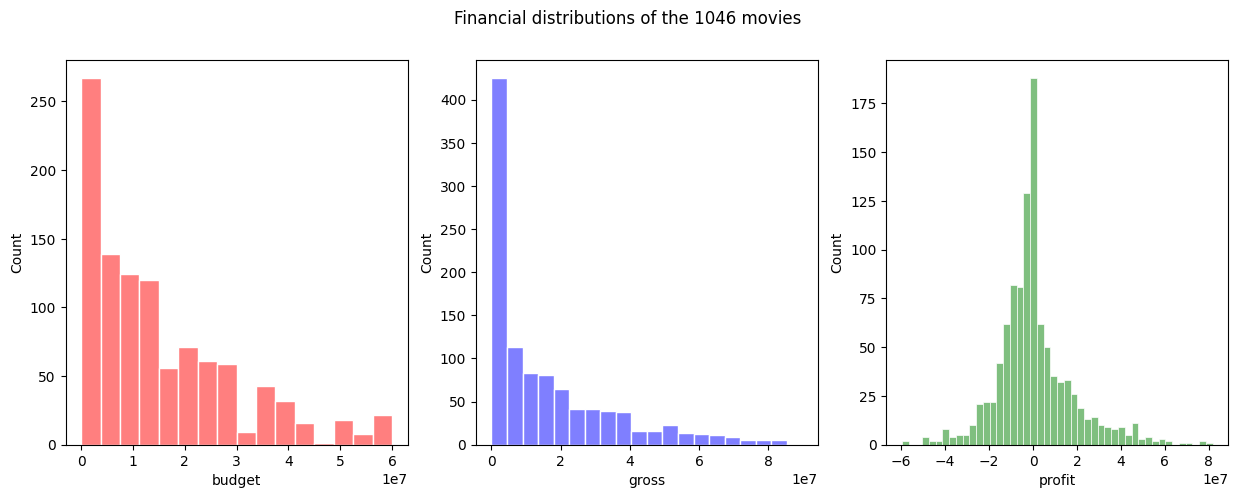

In [224]:
# Initialize the class and prepare the data
steve = MDO_Statistician.from_enriched(
    pre="../data/pre_release.csv", after="../data/after_release.csv",
    path="../data/enriched_data.csv")
steve.get_dist_financials(plot=True)
steve.show_me_the_world()

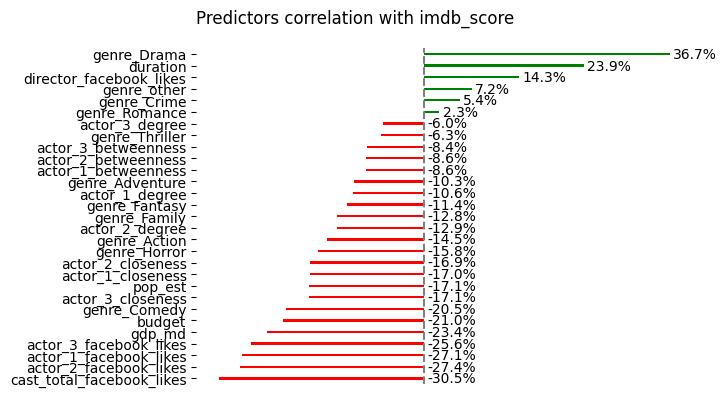

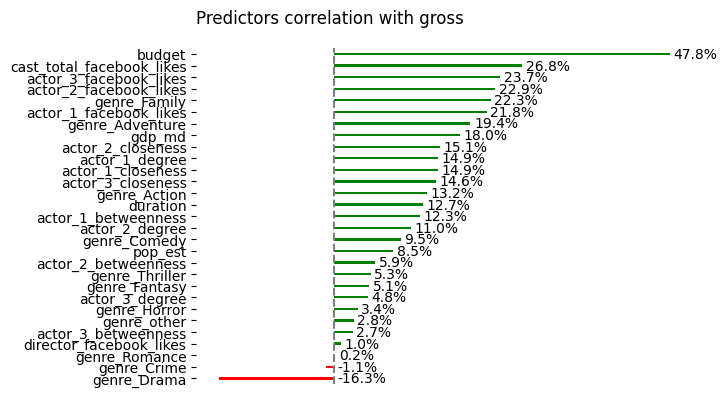

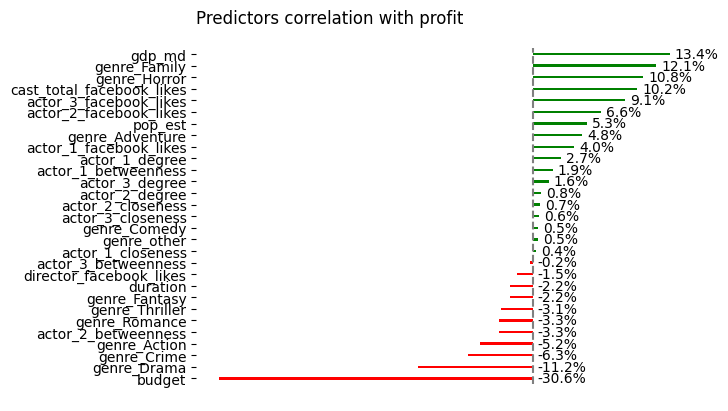

                F-stat imdb_score       p-value
genres                   2.420934  2.293582e-23
content_rating           9.520236  2.962480e-15
director_name            2.273118  8.102686e-12
language                 3.987295  1.349641e-10
country                  3.402983  1.394862e-10
actor_1_name             1.566690  1.226842e-05
actor_2_name             1.192157  1.093015e-01
actor_3_name             1.093225  3.057109e-01
                F-stat gross       p-value
content_rating     11.976577  1.018929e-19
genres              1.682849  3.926007e-09
country             1.690067  7.158829e-03
language            1.689342  1.707702e-02
actor_2_name        1.265941  4.952431e-02
director_name       1.195913  5.993995e-02
actor_1_name        0.981425  5.799356e-01
actor_3_name        0.942536  6.622909e-01
                F-stat profit       p-value
genres               1.680836  4.252693e-09
content_rating       4.959931  4.821211e-07
country              1.930119  9.161153e-04
langu

In [225]:
# Are the financial and public success of a movie comming from the same factors?
_ = steve.get_correlation("imdb_score", plot=True)
_ = steve.get_correlation("gross", plot=True)
_ = steve.get_correlation("profit", plot=True)

print(steve.get_anova("imdb_score"))
print(steve.get_anova("gross"))
print(steve.get_anova("profit"))

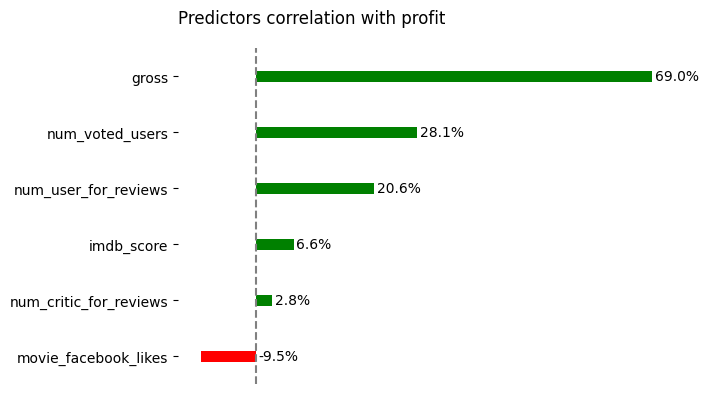

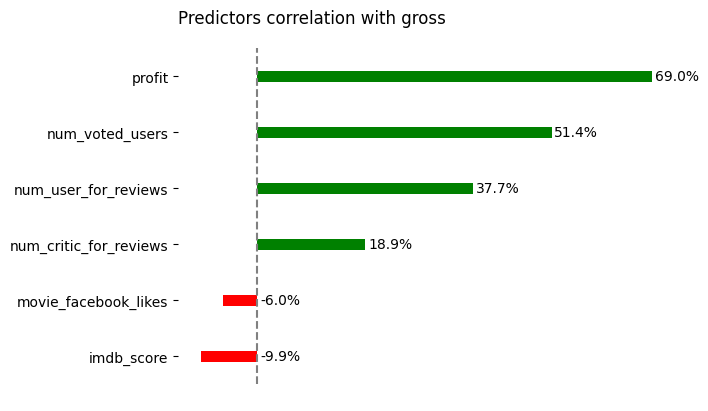

In [226]:
# Are the metrics of success correlated?
_ = steve.get_correlation(
    predictors=[col for col in steve.success_columns if col != "profit"],
    target="profit", plot=True)
_ = steve.get_correlation(
    predictors=[col for col in steve.success_columns if col != "gross"],
    target="gross", plot=True)

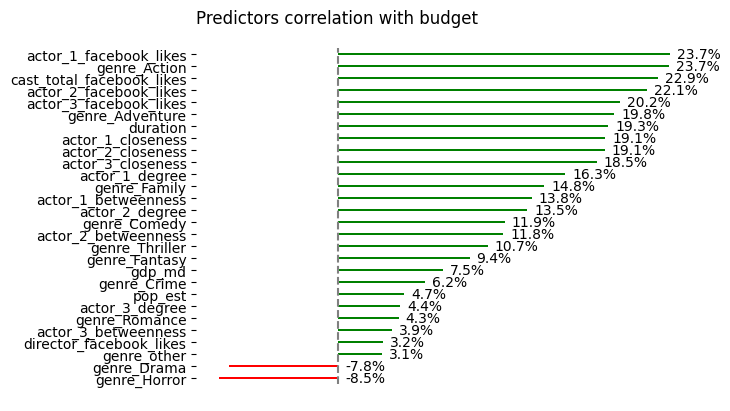

In [227]:
keep = list(steve.full[steve.pred_columns].dtypes.isin(["int64", "bool", "float64"]).values)
col_to_keep = [col for col, keep in zip(steve.pred_columns, keep) if keep and col != "budget"]

_ = steve.get_correlation(
    predictors=col_to_keep,
    target="budget", plot=True)


## The Agent

In [248]:
class MDO_Agent(MDO_Researcher):
    """Second employee of the Movie Director Office, the agent knows his way around the movie industry.
    He can provide insights into directors, actors and their relationships.

    Base Class
    ----------
    MDO_Researcher : MDO_Researcher
        Support the agent with the data preparation and enrichment.

    Special Attributes
    ------------------
    network : nx.Graph
        Network of actors

    Special Methods
    ---------------

    get_top_directors(top:int=5, sort_by:str="gross") -> pd.DataFrame
        Get the top directors based on a given criteria and display their information.

    get_info_celebrity(name:str, verbose:bool=True) -> dict
        Fetch information about a celebrity (director or actor) from a trusted colleague.

    create_actors_network(
        save_to:str="../data/actors.pickle",
        load_from:str=None, plot:bool=False) -> nx.Graph
        Create a network of actors based on the movies they played in.
    
    show_nth_cluster(n:int=1) -> None
        Show the nth component of the actors network.
    
    show_n_neighbors(actor:str, degree:int=1, plot:bool=False) -> List[str]
        Show the neighbors of an actor in the network up to n connections.

    """

    def __init__(self, **class_arg):
        super().__init__(**class_arg)
        self.network = None

    #># Method 1:

    def get_top_directors(self, top:int=5, sort_by:str="gross") -> pd.DataFrame:
        """Get the top directors based on a given criteria.

        Parameters
        ----------
        top : int, optional
            Number of directors to display, by default 5
        criteria : str, optional
            Criteria to sort the directors, by default "gross"
            Choose from "budget", "gross", "profit", "imdb_score" or "director_facebook_likes"

        Returns
        -------
        pd.DataFrame
            DataFrame with the top directors
        """

        # Define the information to gather for the directors
        criteria = ["budget", "gross", "profit", "imdb_score", "director_facebook_likes"]
        infos = ["director_name","movie_title", "language", "country"]
        genres = [col for col in self.full.columns if "genre_" in col]

        # Group by director and aggregate the information
        top_directors = self.full[criteria+infos+genres].groupby("director_name").agg({
            **{col:"mean" for col in criteria},
            "movie_title":"count", "language":pd.Series.mode, "country":pd.Series.mode,
            **{col:"sum" for col in genres}
        }).sort_values(by=sort_by, ascending=False).head(top)
        top_directors.columns = [
            "Average budget", "Average gross", "Average profit", "Average imdb score", "Average director facebook likes",
            "Number of movies", "Most common language", "Most common country", *genres
        ]

        # Return the top directors
        return top_directors
    
    #># Method 2:

    def get_info_celebrity(self, name:str, verbose:bool=True) -> dict:
        """Get information about a celebrity.

        Parameters
        ----------
        name : str
            Name of the celebrity (director or actor)
        verbose : bool, optional
            Display the information, by default True

        Returns
        -------
        dict
            Information about the celebrity
        """

        # Create the API URL
        api_url = 'https://api.api-ninjas.com/v1/celebrity?name={}'.format(name)

        # Use environment variable to keep the API KEY private when shared
        response = requests.get(api_url, headers={'X-Api-Key': os.environ.get("NINJA_API_KEY", None)})
        
        # Catch eventual failed requests
        if response.status_code == requests.codes.ok:
            details = (response.json()[0])
            if verbose:
                print(f"Here is all I know about {name}:")
                for key, value in details.items():
                    print(f"  - {key}: {value}")
            return details
        else:
            print(f"I'm sorry, I don't know much about {name}.")
            return {}

    #># Method 3:

    def create_actors_network(
            self,
            save_to:str= "../data/actors.pickle",
            load_from:str = None,
            plot:bool=False) -> nx.Graph:        
        """Create a network of actors based on the movies they played in.

        Parameters
        ----------
        save_to : str, optional
            Path to save the network, by default "../data/actors.pickle"
        load_from : str, optional
            Path to load the network from, by default None
        plot : bool, optional
            Plot the network, by default False

        Returns
        -------
        nx.Graph
            Network of actors
        """

        if save_to is not None and load_from is None:
            # Reformat existing data to have the movie-actor pairs
            actor1 = self.full[["movie_title", "actor_1_name"]].rename(columns={"actor_1_name": "actor"})
            actor2 = self.full[["movie_title", "actor_2_name"]].rename(columns={"actor_2_name": "actor"})
            actor3 = self.full[["movie_title", "actor_3_name"]].rename(columns={"actor_3_name": "actor"})
            actors = pd.concat([actor1, actor2, actor3], ignore_index=True)
            actors["movie_title"] = actors["movie_title"].apply(lambda x: x.strip())

            # Group the movies by actors
            graph_data = actors.groupby("actor")["movie_title"].apply(list).reset_index()

            # Create the network
            self.network = nx.Graph()

            # For each actor, add edges with other actors they played with
            for i, (actor, movies) in graph_data.iterrows():
                self.network.add_node(actor)
                print(f"Network creation: {(i+1)/len(graph_data):.2%}", end="\r")
                for _, (actor2, movies2) in graph_data.iloc[i+1:].iterrows():
                    common_movies = set(movies).intersection(set(movies2))
                    if len(common_movies) > 0:
                        self.network.add_edge(actor, actor2, weight=len(common_movies))
            
            # Save the network
            pickle.dump(self.network, open(save_to, "wb"))
        
        elif save_to is None and load_from is not None:
            self.network = pickle.load(open(load_from, "rb"))

        else:
            raise ValueError("You need to choose either to save or to load the network")
        
        # Plot the network
        if plot:
            nx.draw(self.network, with_labels=False, node_size=2)
            plt.show()
    
        return self.network
    
    #># Method 4:

    def show_nth_cluster(self, n:int=1) -> None:
        """Show the nth component of the actors network.

        Parameters
        ----------
        n : int, optional
            Number of the component to display from largest, by default 1

        Returns
        -------
        None
            Display the network component
        """

        # Get the components and order them by size
        components = sorted(nx.connected_components(self.network), key=len, reverse=True)
        chosen_component = list(components[n-1])

        # Plot the chosen component
        subgraph = self.network.subgraph(chosen_component)
        nx.draw(subgraph, with_labels=True, node_size=10, font_size=10, edge_color="lightgrey")
        plt.title(f"Component {n} of the actors network ({len(chosen_component)} actors)")
        plt.show()
    
    #># Method 5:

    def show_n_neighbors(self, actor:str, degree:int=1, plot:bool=False) -> None:
        """Show the neighbors of an actor in the network up to n connections.

        Parameters
        ----------
        actor : str
            Name of the actor
        degree : int, optional
            Number of neighbors to display, by default 1
        plot : bool, optional
            Plot the network, by default False

        Returns
        -------
        List[str]
            List of the neighbors
        
        Raises
        ------
        KeyError
            If the actor is not found in the network
        """

        # Get the neighbors of the actor
        sub_nodes = [actor]
        try:
            sub_nodes = list(nx.single_source_shortest_path(self.network, actor, cutoff=degree).keys())
        except KeyError:
            raise KeyError(f"{actor} is not in the network")
        
        # Show the subgraph of the neighbors
        if plot:
            subgraph = self.network.subgraph(sub_nodes)
            color_map = ["lightgreen" if node == actor else "lightblue" for node in subgraph.nodes()]
            size_map = [100 if node == actor else 10 for node in subgraph.nodes()]
            nx.draw(
                subgraph, with_labels=True, node_size=size_map, node_color=color_map,
                font_size=10, edge_color="lightgrey")
            plt.title(f"Neighbors of {actor} up to degree {degree} (n={len(sub_nodes) - 1})")
            plt.show()
        
        sub_nodes.remove(actor)
        sub_nodes.sort()
        return sub_nodes


### Demo

In [249]:
josh = MDO_Agent.from_enriched(
    pre="../data/pre_release.csv",
    after="../data/after_release.csv",
    path="../data/enriched_data.csv")

print("Who directed the most movies?")
display(josh.get_top_directors(3, "movie_title"))
print("Who made the most action movies?")
display(josh.get_top_directors(3, "genre_Action"))

Who directed the most movies?


,Average budget,Average gross,Average profit,Average imdb score,Average director facebook likes,Number of movies,Most common language,Most common country,genre_Drama,genre_Comedy,genre_Romance,genre_Thriller,genre_Crime,genre_Action,genre_Adventure,genre_Horror,genre_Family,genre_Fantasy,genre_other
director_name,,,,,,,,,,,,,,,,,,,
Spike Lee,6.867857e+06,1.233011e+07,5.462248e+06,6.300,0.0,7,English,USA,5,6,1,0,0,0,0,0,0,0,4
Brian De Palma,1.462500e+07,1.498156e+07,3.565618e+05,6.400,0.0,4,English,USA,2,0,1,4,3,0,0,0,0,0,3
Barry Levinson,1.925000e+07,7.651720e+06,-1.159828e+07,6.275,272.0,4,English,USA,1,3,0,1,0,0,1,0,0,1,1


Who made the most action movies?


,Average budget,Average gross,Average profit,Average imdb score,Average director facebook likes,Number of movies,Most common language,Most common country,genre_Drama,genre_Comedy,genre_Romance,genre_Thriller,genre_Crime,genre_Action,genre_Adventure,genre_Horror,genre_Family,genre_Fantasy,genre_other
director_name,,,,,,,,,,,,,,,,,,,
John Glen,2.987500e+07,5.101323e+07,21138228.0,6.550000,46.0,4,English,UK,0,0,0,4,0,4,4,0,0,0,0
Lewis Gilbert,1.916667e+07,5.086667e+07,31700000.0,6.766667,43.0,3,English,UK,0,0,0,3,0,3,3,0,0,0,2
Les Mayfield,2.933333e+07,9.898363e+06,-19434970.0,5.333333,10.0,3,English,USA,0,2,0,0,2,3,0,0,0,0,1


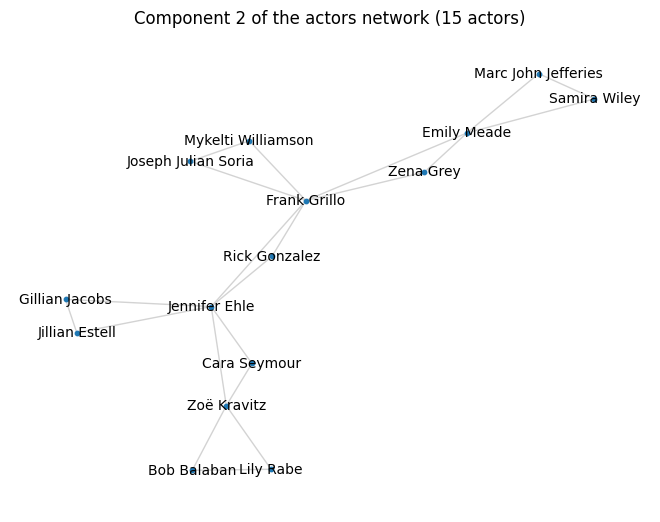

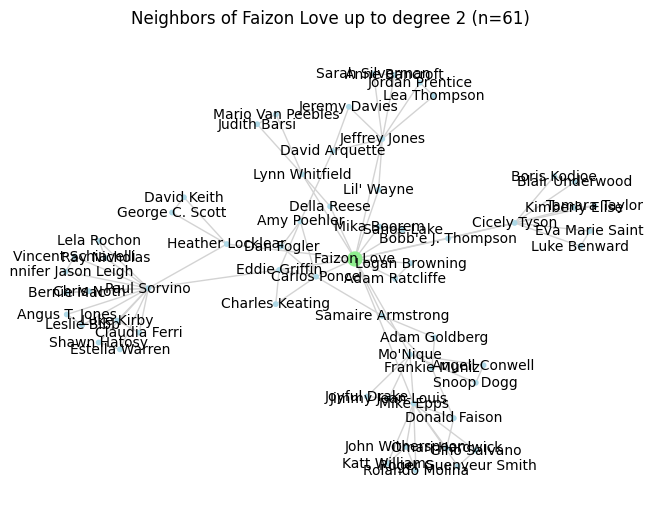

['Adam Goldberg',
 'Adam Ratcliffe',
 'Amy Poehler',
 'Angell Conwell',
 'Angus T. Jones',
 'Anne Bancroft',
 'Bernie Mac',
 'Blair Underwood',
 "Bobb'e J. Thompson",
 'Boris Kodjoe',
 'Carlos Ponce',
 'Charles Keating',
 'Chris Noth',
 'Cicely Tyson',
 'Claudia Ferri',
 'Dan Fogler',
 'David Arquette',
 'David Keith',
 'Della Reese',
 'Donald Faison',
 'Eddie Griffin',
 'Estella Warren',
 'Eva Marie Saint',
 'Frankie Muniz',
 'George C. Scott',
 'Gino Salvano',
 'Heather Locklear',
 'Jeffrey Jones',
 'Jennifer Jason Leigh',
 'Jeremy Davies',
 'Jimmy Jean-Louis',
 'John Witherspoon',
 'Jordan Prentice',
 'Joyful Drake',
 'Judith Barsi',
 'Katt Williams',
 'Kimberly Elise',
 'Lea Thompson',
 'Lela Rochon',
 'Leslie Bibb',
 "Lil' Wayne",
 'Logan Browning',
 'Luke Benward',
 'Luke Kirby',
 'Lynn Whitfield',
 'Mario Van Peebles',
 'Mika Boorem',
 'Mike Epps',
 "Mo'Nique",
 'Omari Hardwick',
 'Paul Sorvino',
 'Ray Nicholas',
 'Roger Guenveur Smith',
 'Rolando Molina',
 'Samaire Armstrong',


In [250]:
# josh.create_actors_network(save_to="../data/actors.pickle", plot=True)

most_connected_actor = josh.full.iloc[josh.full["actor_1_degree"].idxmax()]["actor_1_name"]
josh.create_actors_network(load_from="../data/actors.pickle", save_to=None, plot=False)
josh.show_nth_cluster(2)
josh.show_n_neighbors(most_connected_actor, degree=2, plot=True)

In [251]:
# josh.get_info_celebrity("Bruce Willis")
# josh.get_info_cebrity("Quentin Tarantino")

Here is all I know about Bruce Willis:
  - name: bruce willis
  - net_worth: 250000000
  - gender: male
  - nationality: us
  - occupation: ['actor', 'film_producer', 'television_producer', 'businessperson', 'voice_actor', 'singer', 'musician', 'writer', 'composer']
  - height: 1.83
  - birthday: 1955-03-19
  - age: 69
  - is_alive: True


{'name': 'bruce willis',
 'net_worth': 250000000,
 'gender': 'male',
 'nationality': 'us',
 'occupation': ['actor',
  'film_producer',
  'television_producer',
  'businessperson',
  'voice_actor',
  'singer',
  'musician',
  'writer',
  'composer'],
 'height': 1.83,
 'birthday': '1955-03-19',
 'age': 69,
 'is_alive': True}